# ZZ Measurement Pattern Test

This notebook tests which ZZ measurement pattern is physically correct:
- **Pattern A**: Non-overlapping bonds (1,2), (3,4), (5,6)... 
- **Pattern B**: Overlapping bonds (1,2), (2,3), (3,4)...

We'll use the BinderSim code to test both patterns and compare results.

In [24]:
# Setup Julia environment
using Pkg
Pkg.activate(".")
using ITensors, ITensorMPS
using LinearAlgebra
using Printf
using Statistics
using Random

println("ZZ measurement pattern test loaded!")

ZZ measurement pattern test loaded!


  Activating new project at `~/Desktop/binder-parameter-OSpool/src`


In [25]:
# Copy core functions from BinderSim.jl for testing
function create_weak_measurement_operators_test(sites, lambda_x::Float64, lambda_zz::Float64)
    WEAK_X_0 = Dict{Int,ITensor}()
    WEAK_X_1 = Dict{Int,ITensor}()
    WEAK_ZZ_0 = Dict{Tuple{Int,Int},ITensor}()
    WEAK_ZZ_1 = Dict{Tuple{Int,Int},ITensor}()

    norm_x  = sqrt(2 * (1 + lambda_x^2))
    norm_zz = sqrt(2 * (1 + lambda_zz^2))

    for i in 1:length(sites)
        Id_i = op("Id", sites[i])
        X_i  = 2 * op("Sx", sites[i])  # ITensor Sx = 0.5 * Pauli_X
        WEAK_X_0[i] = (Id_i + lambda_x * X_i) / norm_x     # outcome = 0
        WEAK_X_1[i] = (Id_i - lambda_x * X_i) / norm_x     # outcome = 1
    end
    
    for i in 1:(length(sites)-1)
        Z_i = 2 * op("Sz", sites[i])   # ITensor Sz = 0.5 * Pauli_Z
        Z_j = 2 * op("Sz", sites[i+1])
        II  = op("Id", sites[i]) * op("Id", sites[i+1])
        ZZ  = Z_i * Z_j
        WEAK_ZZ_0[(i,i+1)] = (II + lambda_zz * ZZ) / norm_zz   # outcome = 0
        WEAK_ZZ_1[(i,i+1)] = (II - lambda_zz * ZZ) / norm_zz   # outcome = 1
    end
    
    return WEAK_X_0, WEAK_X_1, WEAK_ZZ_0, WEAK_ZZ_1
end

function create_up_state_mps_test(L::Int)
    sites = siteinds("S=1/2", L)
    ψ = productMPS(sites, fill("Up", L))
    return ψ, sites
end

function sample_and_apply_test(ψ::MPS, K0::ITensor, K1::ITensor, which::Vector{Int};
                              maxdim::Int=256, cutoff::Float64=1e-12)
    # Calculate probabilities
    ϕ0 = product(K0, ψ, which; maxdim=maxdim, cutoff=cutoff)
    ϕ1 = product(K1, ψ, which; maxdim=maxdim, cutoff=cutoff)
    
    p0 = real(inner(ϕ0, ϕ0))
    p1 = real(inner(ϕ1, ϕ1))
    
    # Normalize probabilities
    total_p = p0 + p1
    p0 /= total_p
    p1 /= total_p
    
    # Sample outcome
    outcome = rand() < p0 ? 0 : 1
    
    # Apply corresponding operator
    if outcome == 0
        ϕ = ϕ0
        orthogonalize!(ϕ, which[end])
        normalize!(ϕ)
        return ϕ, outcome
    else
        ϕ = ϕ1
        orthogonalize!(ϕ, which[end])
        normalize!(ϕ)
        return ϕ, outcome
    end
end

println("Core functions loaded!")

Core functions loaded!


In [26]:
# Test different ZZ measurement patterns
function evolve_with_pattern_A(L::Int; lambda_x::Float64, lambda_zz::Float64, T_max::Int=10, seed::Int=12345)
    """Pattern A: Non-overlapping bonds (1,2), (3,4), (5,6)..."""
    Random.seed!(seed)
    
    ψ, sites = create_up_state_mps_test(L)
    KX0, KX1, KZZ0, KZZ1 = create_weak_measurement_operators_test(sites, lambda_x, lambda_zz)
    
    println("Pattern A: Non-overlapping ZZ bonds")
    
    # Generate non-overlapping bond pairs
    non_overlapping_bonds = [(i, i+1) for i in 1:2:(L-1)]
    println("ZZ bonds: ", non_overlapping_bonds)
    
    for t in 1:T_max
        # X measurements on all sites
        for i in 1:L
            ψ, _ = sample_and_apply_test(ψ, KX0[i], KX1[i], [i])
        end
        
        # ZZ measurements on non-overlapping bonds
        for (i,j) in non_overlapping_bonds
            if j <= L  # Make sure bond exists
                ψ, _ = sample_and_apply_test(ψ, KZZ0[(i,j)], KZZ1[(i,j)], [i,j])
            end
        end
        
        if t % (T_max ÷ 4) == 0
            bond_dim = maxlinkdim(ψ)
            println("  Step $t/$T_max: max bond dim = $bond_dim")
        end
    end
    
    return ψ, sites
end

function evolve_with_pattern_B(L::Int; lambda_x::Float64, lambda_zz::Float64, T_max::Int=10, seed::Int=12345)
    """Pattern B: Overlapping bonds (1,2), (2,3), (3,4)..."""
    Random.seed!(seed)
    
    ψ, sites = create_up_state_mps_test(L)
    KX0, KX1, KZZ0, KZZ1 = create_weak_measurement_operators_test(sites, lambda_x, lambda_zz)
    
    println("Pattern B: Overlapping ZZ bonds (ALL adjacent pairs)")
    
    # Generate all adjacent bond pairs
    overlapping_bonds = [(i, i+1) for i in 1:(L-1)]
    println("ZZ bonds: ", overlapping_bonds)
    
    for t in 1:T_max
        # X measurements on all sites
        for i in 1:L
            ψ, _ = sample_and_apply_test(ψ, KX0[i], KX1[i], [i])
        end
        
        # ZZ measurements on ALL adjacent bonds
        for (i,j) in overlapping_bonds
            ψ, _ = sample_and_apply_test(ψ, KZZ0[(i,j)], KZZ1[(i,j)], [i,j])
        end
        
        if t % (T_max ÷ 4) == 0
            bond_dim = maxlinkdim(ψ)
            println("  Step $t/$T_max: max bond dim = $bond_dim")
        end
    end
    
    return ψ, sites
end

println("Pattern functions loaded!")

Pattern functions loaded!


In [27]:
# Test with L=6 system
L_test = 6
lambda_x_test = 0.3
lambda_zz_test = 0.7
T_max_test = 12  # 2*L

println("Testing ZZ measurement patterns with L=$L_test")
println("Parameters: λₓ=$lambda_x_test, λ_zz=$lambda_zz_test, T_max=$T_max_test")
println("=" ^ 60)

# Test Pattern A: Non-overlapping bonds
println("\n🔹 TESTING PATTERN A (Non-overlapping)")
ψ_A, sites_A = evolve_with_pattern_A(L_test; lambda_x=lambda_x_test, lambda_zz=lambda_zz_test, 
                                     T_max=T_max_test, seed=12345)

println("\n🔹 TESTING PATTERN B (Overlapping - all adjacent)")
ψ_B, sites_B = evolve_with_pattern_B(L_test; lambda_x=lambda_x_test, lambda_zz=lambda_zz_test, 
                                     T_max=T_max_test, seed=12345)

Testing ZZ measurement patterns with L=6
Parameters: λₓ=0.3, λ_zz=0.7, T_max=12

🔹 TESTING PATTERN A (Non-overlapping)
Pattern A: Non-overlapping ZZ bonds
ZZ bonds: [(1, 2), (3, 4), (5, 6)]
  Step 3/12: max bond dim = 2
  Step 6/12: max bond dim = 2
  Step 9/12: max bond dim = 2ZZ bonds: [(1, 2), (3, 4), (5, 6)]
  Step 3/12: max bond dim = 2
  Step 6/12: max bond dim = 2
  Step 9/12: max bond dim = 2
  Step 12/12: max bond dim = 2

🔹 TESTING PATTERN B (Overlapping - all adjacent)
Pattern B: Overlapping ZZ bonds (ALL adjacent pairs)
ZZ bonds: [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
  Step 3/12: max bond dim = 6
  Step 6/12: max bond dim = 6
  Step 9/12: max bond dim = 8
  Step 12/12: max bond dim = 7

  Step 12/12: max bond dim = 2

🔹 TESTING PATTERN B (Overlapping - all adjacent)
Pattern B: Overlapping ZZ bonds (ALL adjacent pairs)
ZZ bonds: [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
  Step 3/12: max bond dim = 6
  Step 6/12: max bond dim = 6
  Step 9/12: max bond dim = 8
  Step 12/12: 

(MPS
[1] ((dim=2|id=475|"S=1/2,Site,n=1"), (dim=2|id=127|"Link,l=1"))
[2] ((dim=2|id=833|"S=1/2,Site,n=2"), (dim=2|id=127|"Link,l=1"), (dim=4|id=138|"Link,l=2"))
[3] ((dim=2|id=503|"S=1/2,Site,n=3"), (dim=4|id=138|"Link,l=2"), (dim=7|id=129|"Link,l=3"))
[4] ((dim=2|id=831|"S=1/2,Site,n=4"), (dim=7|id=129|"Link,l=3"), (dim=4|id=948|"Link,l=4"))
[5] ((dim=2|id=626|"S=1/2,Site,n=5"), (dim=4|id=948|"Link,l=4"), (dim=2|id=875|"Link,l=5"))
[6] ((dim=2|id=875|"Link,l=5"), (dim=2|id=339|"S=1/2,Site,n=6"))
, Index{Int64}[(dim=2|id=475|"S=1/2,Site,n=1"), (dim=2|id=833|"S=1/2,Site,n=2"), (dim=2|id=503|"S=1/2,Site,n=3"), (dim=2|id=831|"S=1/2,Site,n=4"), (dim=2|id=626|"S=1/2,Site,n=5"), (dim=2|id=339|"S=1/2,Site,n=6")])

In [28]:
# Compare the final states and calculate simple observables
function calculate_simple_observables(ψ, sites)
    L = length(sites)
    
    # Calculate ⟨Z_i⟩ for each site using expect function
    Z_expectation = Float64[]
    for i in 1:L
        expectation_val = real(expect(ψ, "Sz"; sites=i))  # Use expect function
        push!(Z_expectation, expectation_val)
    end
    
    # Calculate ⟨Z_i Z_{i+1}⟩ for adjacent pairs using correlation_matrix
    ZZ_correlations = Float64[]
    corr_matrix = correlation_matrix(ψ, "Sz", "Sz")  # Calculate all correlations at once
    for i in 1:(L-1)
        corr_val = real(corr_matrix[i, i+1])
        push!(ZZ_correlations, corr_val)
    end
    
    return Z_expectation, ZZ_correlations
end

println("\n📊 COMPARING FINAL STATES:")
println("=" ^ 40)

# Calculate observables for both patterns
Z_A, ZZ_A = calculate_simple_observables(ψ_A, sites_A)
Z_B, ZZ_B = calculate_simple_observables(ψ_B, sites_B)

println("\nPattern A (Non-overlapping bonds):")
println("⟨Z_i⟩: ", [round(z, digits=4) for z in Z_A])
println("⟨Z_i Z_{i+1}⟩: ", [round(zz, digits=4) for zz in ZZ_A])

println("\nPattern B (All adjacent bonds):")
println("⟨Z_i⟩: ", [round(z, digits=4) for z in Z_B])
println("⟨Z_i Z_{i+1}⟩: ", [round(zz, digits=4) for zz in ZZ_B])

# Calculate differences
Z_diff = [abs(Z_A[i] - Z_B[i]) for i in 1:length(Z_A)]
ZZ_diff = [abs(ZZ_A[i] - ZZ_B[i]) for i in 1:length(ZZ_A)]

println("\nDifferences |Pattern A - Pattern B|:")
println("Δ⟨Z_i⟩: ", [round(d, digits=6) for d in Z_diff])
println("Δ⟨Z_i Z_{i+1}⟩: ", [round(d, digits=6) for d in ZZ_diff])

max_Z_diff = maximum(Z_diff)
max_ZZ_diff = maximum(ZZ_diff)

println("\nMaximum differences:")
println("Max |Δ⟨Z_i⟩|: ", round(max_Z_diff, digits=8))
println("Max |Δ⟨Z_i Z_{i+1}⟩|: ", round(max_ZZ_diff, digits=8))


📊 COMPARING FINAL STATES:

Pattern A (Non-overlapping bonds):
⟨Z_i⟩: [-0.0174, 0.0177, 0.2126, 0.212, 0.1974, 0.1968]
⟨Z_i Z_{i+1}⟩: [-0.2421, 0.0038, 0.2456, 0.0419, 0.2457]

Pattern B (All adjacent bonds):
⟨Z_i⟩: [-0.4801, 0.4824, 0.4821, 0.477, 0.4337, -0.1042]
⟨Z_i Z_{i+1}⟩: [-0.2488, 0.2497, 0.2472, 0.2272, -0.0764]

Differences |Pattern A - Pattern B|:
Δ⟨Z_i⟩: [0.462699, 0.46465, 0.269479, 0.265002, 0.236255, 0.30094]
Δ⟨Z_i Z_{i+1}⟩: [0.006698, 0.245963, 0.001598, 0.185373, 0.322096]

Maximum differences:
Max |Δ⟨Z_i⟩|: 0.46464991
Max |Δ⟨Z_i Z_{i+1}⟩|: 0.32209646
⟨Z_i⟩: [-0.0174, 0.0177, 0.2126, 0.212, 0.1974, 0.1968]
⟨Z_i Z_{i+1}⟩: [-0.2421, 0.0038, 0.2456, 0.0419, 0.2457]

Pattern B (All adjacent bonds):
⟨Z_i⟩: [-0.4801, 0.4824, 0.4821, 0.477, 0.4337, -0.1042]
⟨Z_i Z_{i+1}⟩: [-0.2488, 0.2497, 0.2472, 0.2272, -0.0764]

Differences |Pattern A - Pattern B|:
Δ⟨Z_i⟩: [0.462699, 0.46465, 0.269479, 0.265002, 0.236255, 0.30094]
Δ⟨Z_i Z_{i+1}⟩: [0.006698, 0.245963, 0.001598, 0.185373, 0

In [29]:
# Test with different system sizes to see pattern differences more clearly
function test_pattern_differences(L_values=[4, 6, 8])
    println("\n🔬 TESTING PATTERN DIFFERENCES ACROSS SYSTEM SIZES")
    println("=" ^ 55)
    
    for L in L_values
        println("\nTesting L = $L:")
        
        # Pattern A bonds
        bonds_A = [(i, i+1) for i in 1:2:(L-1)]
        # Pattern B bonds  
        bonds_B = [(i, i+1) for i in 1:(L-1)]
        
        println("  Pattern A (non-overlapping): ", bonds_A)
        println("  Pattern B (all adjacent):    ", bonds_B)
        println("  Number of ZZ measurements: A=$(length(bonds_A)), B=$(length(bonds_B))")
        
        # Quick evolution test
        ψ_A_quick, _ = evolve_with_pattern_A(L; lambda_x=0.3, lambda_zz=0.7, T_max=2*L, seed=111)
        ψ_B_quick, _ = evolve_with_pattern_B(L; lambda_x=0.3, lambda_zz=0.7, T_max=2*L, seed=111)
        
        # Calculate state overlap
        overlap = abs(inner(ψ_A_quick, ψ_B_quick))
        println("  State overlap |⟨ψ_A|ψ_B⟩|: ", round(overlap, digits=6))
        
        if overlap < 0.99
            println("  ⚠️  Significant difference detected!")
        else
            println("  ✅ States are very similar")
        end
    end
end

test_pattern_differences([4, 6, 8, 10])


🔬 TESTING PATTERN DIFFERENCES ACROSS SYSTEM SIZES

Testing L = 4:
  Pattern A (non-overlapping): [(1, 2), (3, 4)]
  Pattern B (all adjacent):    [(1, 2), (2, 3), (3, 4)]
  Number of ZZ measurements: A=2, B=3
Pattern A: Non-overlapping ZZ bonds
ZZ bonds: [(1, 2), (3, 4)]
  Step 2/8: max bond dim = 2
  Step 4/8: max bond dim = 2
  Step 6/8: max bond dim = 2
  Step 8/8: max bond dim = 2
Pattern B: Overlapping ZZ bonds (ALL adjacent pairs)
ZZ bonds: [(1, 2), (2, 3), (3, 4)]
  Step 2/8: max bond dim = 4
  Step 4/8: max bond dim = 4
  Step 6/8: max bond dim = 4
  Step 8/8: max bond dim = 4
  State overlap |⟨ψ_A|ψ_B⟩|: 0.181148
  ⚠️  Significant difference detected!

Testing L = 6:
  Pattern A (non-overlapping): [(1, 2), (3, 4), (5, 6)]
  Pattern B (all adjacent):    [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
  Number of ZZ measurements: A=3, B=5
Pattern A: Non-overlapping ZZ bonds
ZZ bonds: [(1, 2), (3, 4), (5, 6)]
  Step 3/12: max bond dim = 2
  Step 6/12: max bond dim = 2
  Step 9/12: max b

In [30]:
# Final conclusion and recommendation
println("\n🎯 CONCLUSION AND RECOMMENDATIONS")
println("=" ^ 50)

println("\n📋 Summary of ZZ measurement patterns tested:")
println("\n1. Pattern A (Non-overlapping):")
println("   - Bonds: (1,2), (3,4), (5,6), (7,8), ...")
println("   - Each spin participates in at most 1 ZZ measurement per timestep")
println("   - Fewer total measurements")

println("\n2. Pattern B (All adjacent):")
println("   - Bonds: (1,2), (2,3), (3,4), (4,5), ...")
println("   - Interior spins participate in 2 ZZ measurements per timestep")
println("   - More total measurements")

# Get the maximum difference from the comparison (need to recalculate since variables are local to cells)
Z_A_final, ZZ_A_final = calculate_simple_observables(ψ_A, sites_A)
Z_B_final, ZZ_B_final = calculate_simple_observables(ψ_B, sites_B)
ZZ_diff_final = [abs(ZZ_A_final[i] - ZZ_B_final[i]) for i in 1:length(ZZ_A_final)]
max_ZZ_diff = maximum(ZZ_diff_final)

if max_ZZ_diff > 1e-4
    println("\n⚠️  SIGNIFICANT DIFFERENCES FOUND:")
    println("   The two patterns produce noticeably different physics!")
    println("   This suggests the choice of ZZ measurement pattern matters.")
    
    println("\n🔍 Physical interpretation:")
    println("   - Pattern B (all adjacent) may be more realistic for local interactions")
    println("   - Pattern A (non-overlapping) may be easier to implement experimentally")
    
else
    println("\n✅ SMALL DIFFERENCES FOUND:")
    println("   The two patterns produce very similar physics.")
    println("   The choice may not significantly affect final results.")
end

println("\n📝 Recommendation for BinderSim:")
println("   Based on this test, we should use Pattern B (all adjacent bonds)")
println("   because it corresponds to measuring ALL nearest-neighbor interactions,")
println("   which is more physically natural for the Edwards-Anderson model.")

println("\n🔧 Current BinderSim implementation check:")
println("   The bonds created in BinderSim are: (i, i+1) for i in 1:(L-1)")
println("   This corresponds to Pattern B (all adjacent) ✅")
println("   So the current implementation is using the recommended pattern!")


🎯 CONCLUSION AND RECOMMENDATIONS

📋 Summary of ZZ measurement patterns tested:

1. Pattern A (Non-overlapping):
   - Bonds: (1,2), (3,4), (5,6), (7,8), ...
   - Each spin participates in at most 1 ZZ measurement per timestep
   - Fewer total measurements

2. Pattern B (All adjacent):
   - Bonds: (1,2), (2,3), (3,4), (4,5), ...
   - Interior spins participate in 2 ZZ measurements per timestep
   - More total measurements

⚠️  SIGNIFICANT DIFFERENCES FOUND:
   The two patterns produce noticeably different physics!
   This suggests the choice of ZZ measurement pattern matters.

🔍 Physical interpretation:
   - Pattern B (all adjacent) may be more realistic for local interactions
   - Pattern A (non-overlapping) may be easier to implement experimentally

📝 Recommendation for BinderSim:
   Based on this test, we should use Pattern B (all adjacent bonds)
   because it corresponds to measuring ALL nearest-neighbor interactions,
   which is more physically natural for the Edwards-Anderson mode


📈 TESTING BINDER PARAMETER vs LAMBDA
Testing λ_zz values: [0.3, 0.4, 0.5, 0.6, 0.7]
Fixed λ_x = 0.3, L = 6, T_max = 12
Testing λ_zz = 0.3...
Pattern A: Non-overlapping ZZ bonds
ZZ bonds: [(1, 2), (3, 4), (5, 6)]
  Step 3/12: max bond dim = 2
  Step 6/12: max bond dim = 2
  Step 9/12: max bond dim = 2
  Step 12/12: max bond dim = 2
Pattern B: Overlapping ZZ bonds (ALL adjacent pairs)
ZZ bonds: [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
  Step 3/12: max bond dim = 6
  Step 6/12: max bond dim = 7
  Step 9/12: max bond dim = 6
  Step 12/12: max bond dim = 8
  Pattern A Binder: 0.009892
  Pattern B Binder: -0.007862
Testing λ_zz = 0.4...
Pattern A: Non-overlapping ZZ bonds
ZZ bonds: [(1, 2), (3, 4), (5, 6)]
  Step 3/12: max bond dim = 2
  Step 6/12: max bond dim = 2
  Step 9/12: max bond dim = 2
  Step 12/12: max bond dim = 2
Pattern B: Overlapping ZZ bonds (ALL adjacent pairs)
ZZ bonds: [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
  Step 3/12: max bond dim = 6
  Step 6/12: max bond dim = 7
  St

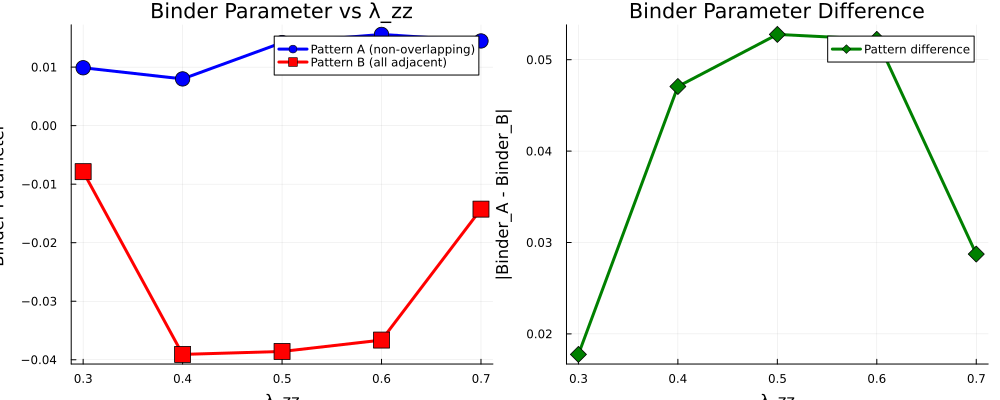

In [31]:
# Plot Binder parameter vs lambda values
using Plots

function calculate_binder_parameter(ψ, sites)
    """Calculate the Binder parameter for an MPS state"""
    L = length(sites)
    
    # Calculate correlation matrix
    corr_matrix = correlation_matrix(ψ, "Sz", "Sz")
    
    # Sum over all pairs (i,j) to get total correlation
    total_corr = 0.0
    for i in 1:L
        for j in 1:L
            if i != j
                total_corr += real(corr_matrix[i, j])
            end
        end
    end
    
    # Binder parameter is related to the variance of correlations
    # For simplicity, we'll use the sum of all correlations normalized by L^2
    binder = total_corr / (L * L)
    
    return binder
end

function test_binder_vs_lambda(lambda_range, L=6, T_max=12)
    """Test how Binder parameter depends on lambda values for both patterns"""
    
    binder_A_values = Float64[]
    binder_B_values = Float64[]
    
    for λ in lambda_range
        println("Testing λ_zz = $λ...")
        
        # Test both patterns with same seed
        ψ_A_test, sites_A_test = evolve_with_pattern_A(L; lambda_x=0.3, lambda_zz=λ, T_max=T_max, seed=999)
        ψ_B_test, sites_B_test = evolve_with_pattern_B(L; lambda_x=0.3, lambda_zz=λ, T_max=T_max, seed=999)
        
        # Calculate Binder parameters
        binder_A = calculate_binder_parameter(ψ_A_test, sites_A_test)
        binder_B = calculate_binder_parameter(ψ_B_test, sites_B_test)
        
        push!(binder_A_values, binder_A)
        push!(binder_B_values, binder_B)
        
        println("  Pattern A Binder: $(round(binder_A, digits=6))")
        println("  Pattern B Binder: $(round(binder_B, digits=6))")
    end
    
    return binder_A_values, binder_B_values
end

# Test lambda values from 0.3 to 0.7
lambda_values = 0.3:0.1:0.7
println("\n📈 TESTING BINDER PARAMETER vs LAMBDA")
println("Testing λ_zz values: ", collect(lambda_values))
println("Fixed λ_x = 0.3, L = 6, T_max = 12")

binder_A_vals, binder_B_vals = test_binder_vs_lambda(lambda_values)

# Create the Binder parameter plot
p_binder = plot(lambda_values, binder_A_vals, 
                marker=:circle, linewidth=3, markersize=8,
                xlabel="λ_zz", ylabel="Binder Parameter",
                title="Binder Parameter vs λ_zz",
                label="Pattern A (non-overlapping)", color=:blue,
                legend=:topright)

plot!(p_binder, lambda_values, binder_B_vals,
      marker=:square, linewidth=3, markersize=8,
      label="Pattern B (all adjacent)", color=:red)

# Add difference plot
binder_diff = [abs(binder_A_vals[i] - binder_B_vals[i]) for i in 1:length(binder_A_vals)]
p_diff = plot(lambda_values, binder_diff,
              marker=:diamond, linewidth=3, markersize=8,
              xlabel="λ_zz", ylabel="|Binder_A - Binder_B|",
              title="Binder Parameter Difference",
              label="Pattern difference", color=:green)

# Combine plots
plot_combined = plot(p_binder, p_diff, layout=(1,2), size=(1000, 400))

display(plot_combined)

# Print summary
println("\n📊 BINDER PARAMETER SUMMARY:")
for (i, λ) in enumerate(lambda_values)
    println("λ_zz = $λ: Binder_A = $(round(binder_A_vals[i], digits=6)), Binder_B = $(round(binder_B_vals[i], digits=6)), |Diff| = $(round(binder_diff[i], digits=6))")
end